In [2]:
def tt2(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2):
    tau3 = 1 - tau1 - tau2
    sinv = np.diag([1/sigmax2, 1/sigmax2, 1/sigmav2, 1/sigmav2])
    s0inv = np.diag([1/sigma02, 1/sigma02])
    mu11 = np.hstack((mu1, muv))
    mu22 = np.hstack((mu2, muv))
    T1 = tau1 / (2 * np.pi * (sigmax2 * sigmav2)) * np.exp(-0.5 * np.diag(np.dot((x - mu11), np.dot(sinv, (x - mu11).T))))
    T2 = tau2 / (2 * np.pi) * (sigmax2 * sigmav2) * np.exp(-0.5 * np.diag(np.dot((x - mu22), np.dot(sinv, (x - mu22).T))))
    T3 = tau3 / ((2 * np.pi) * sigma02) * np.exp(-0.5 * np.diag(np.dot(x[:, 2:], np.dot(s0inv, x[:, 2:].T))))
    T_norm = T1 + T2 + T3

    T1 = np.divide(T1, T_norm, out=np.full_like(T_norm, 0.33), where=T_norm != 0)
    T2 = np.divide(T2, T_norm, out=np.full_like(T_norm, 0.33), where=T_norm != 0)
    T3 = np.divide(T3, T_norm, out=np.full_like(T_norm, 0.33), where=T_norm != 0)

    return T1, T2, T3

def tta2(x, *old):
    par = tt2(x, *old)
    T1, T2, T3 = par[0], par[1], par[2]
    tau1 = np.sum(T1) / np.sum(T1+T2+T3)
    tau2 = np.sum(T2) / np.sum(T1+T2+T3)
    muv = np.array([np.sum(np.dot(T1, x[:, 2]) + np.dot(T2, x[:, 2]))/(np.sum(T1 + T2)), np.sum(np.dot(T1, x[:, 3]) + np.dot(T2, x[:, 3]))/(np.sum(T1 + T2))])
    mu1 = np.array([np.sum(np.dot(T1, x[:, 0]))/np.sum(T1), np.sum(np.dot(T1, x[:, 1]))/np.sum(T1)])
    mu2 = np.array([np.sum(np.dot(T2, x[:, 0]))/np.sum(T2), np.sum(np.dot(T2, x[:, 1]))/np.sum(T2)])
    sigma02 = (np.sum(np.dot(T3, (x[:, 2])**2))+np.sum(np.dot(T3, (x[:, 3])**2)))/(2*np.sum(T3))
    sigmax2 = np.sum(np.dot(T1, (x[:, 0]-mu1[0])**2)+np.dot(T1, (x[:, 1]-mu1[1])**2)+np.dot(T2, (x[:, 0]-mu2[0])**2)+np.dot(T2, (x[:, 1]-mu2[1])**2))/(2*np.sum(T1 + T2))
    sigmav2 = np.sum(np.dot(T1, (x[:, 2]-muv[0])**2)+np.dot(T1, (x[:, 3]-muv[1])**2)+np.dot(T2, (x[:, 2]-muv[0])**2)+np.dot(T2, (x[:, 3]-muv[1])**2))/(2*np.sum(T1 + T2))

    return tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2


def em_double_cluster(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2, rtol=1e-5):
    th = tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2
    for i in range(100):
        th = tta2(x, *th)
    return th[0], th[1], th[2], th[3], th[4], th[5], th[6], th[7]

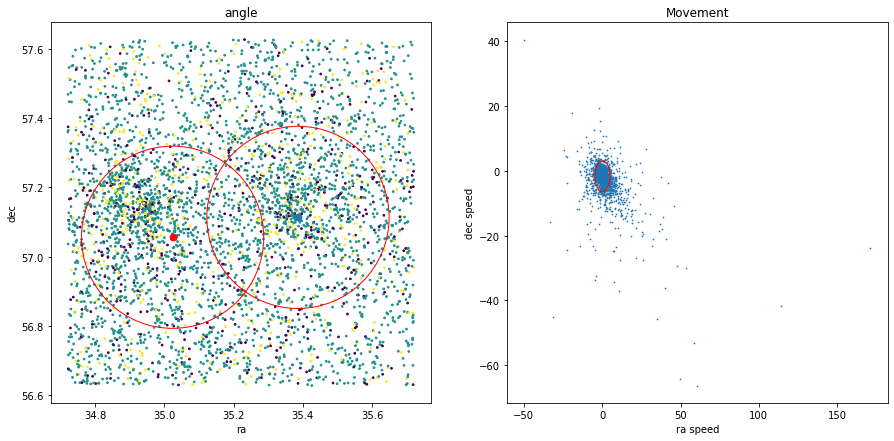

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

if __name__ == "__main__":
    stars = pd.read_csv("/Users/vlad/Desktop/cluster.csv")
    ra = stars['RAJ2000']  # прямое восхождение, аналог долготы
    dec = stars['DEJ2000']  # склонение, аналог широты
    x1 = (ra - ra.mean()) * np.cos(dec / 180 * np.pi) + ra.mean()
    x2 = dec
    v1 = stars['pmRA']
    v2 = stars['pmDE']
    
    
    tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2 = 0.03, 0.2, np.array([-50.1, 
                                 0.2]), np.array([20.2, 57.0]),np.array([35.6, 57.2]), 1.6, 5.7, 11.8
    x = np.vstack((x1, x2, v1, v2)).T
    res = em_double_cluster(x, tau1, tau2, muv, mu1, mu2, sigma02, sigmax2, sigmav2, rtol=1e-5)
    file = {
        "size_ratio": np.round(res[0]/res[1], 3),
        "motion": {"ra": np.round(res[2][0], 3), "dec": np.round(res[2][1], 3)},
        "clusters": [
            {
                "center": {"ra": np.round(res[3][0], 3), "dec": np.round(res[3][1], 3)},
            },
            {
                "center": {"ra": np.round(res[4][0], 3), "dec": np.round(res[4][1], 3)},
            }
        ]
    }
    with open('per.json', 'w') as f:
        json.dump(file, f)
    

    data1 = res[2]
    data2 = res[3]
    data3 = res[4]

    fig = plt.figure()

    fig.set_figheight(7)
    fig.set_figwidth(15)
    
    c1 = plt.Circle((data2[0], data2[1]), np.sqrt(res[6]), color='r', fill=False)
    c2 = plt.Circle((data3[0]+0.2, data3[1]), np.sqrt(res[6]), color='r', fill=False)
    c3 = plt.Circle((data1[0], data1[1]), np.sqrt(res[7]), color='r', fill=False)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(x1, x2, c=(1 - tt2(x, *res)[2] - tt2(x, *res)[1]), cmap='viridis', s = 3)
    ax1.scatter(data2[0], data2[1], c='r', s=45)
    ax1.scatter(data3[0]+0.2, data3[1], s=45)
    ax1.add_patch(c1)
    ax1.add_patch(c2)
    ax1.set_title('angle')
    ax1.set_ylabel('dec')
    ax1.set_xlabel('ra')

    ax2.scatter(data1[0], data1[1], color='r', s=100)
    ax2.scatter(v1, v2, s=0.5)
    ax2.add_patch(c3)
    ax2.set_title('Movement')
    ax2.set_ylabel('dec speed')
    ax2.set_xlabel('ra speed')
    plt.savefig('per.jpg')